# <div style="text-align: center; background-color:black; font-family:Georgia, serif; color: green; padding: 20px;line-height: 1;border-radius:5px; border: 2px solid black;">SPORTS IMAGE CLASSIFICATION</div>

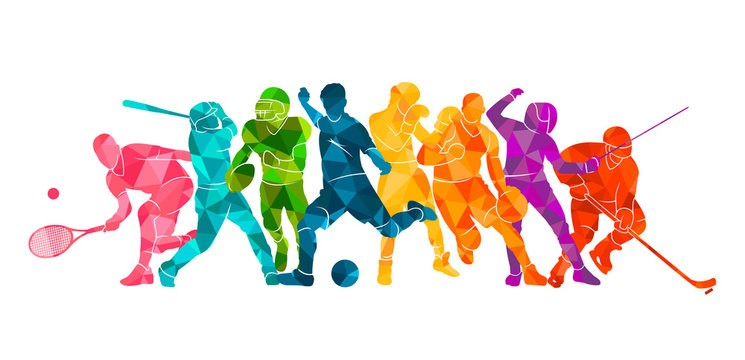

# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import warnings
warnings.simplefilter('ignore')

from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras import applications
import os
import glob
import cv2

In [ ]:
pip install keras==2.15.0

In [ ]:
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D
from keras.layers import AveragePooling2D,GlobalAveragePooling2D,GlobalMaxPool2D,MaxPooling2D,MaxPool2D,Dropout
from keras.models import Model,Sequential

In [ ]:
train=glob.glob('/kaggle/input/sports-classification/train/*')

In [ ]:
train

In [ ]:
glob.glob('/kaggle/input/sports-classification/train/sidecar racing/*')

In [ ]:
img = cv2.imread('/kaggle/input/sports-classification/train/sidecar racing/033.jpg')
print(img.shape)
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img1)

In [ ]:
train_class=os.listdir('/kaggle/input/sports-classification/train/')
train_class

In [ ]:
count_dict1 = {}
img_dict1 = {}

# Loop through classes
for cls in train_class:  # Assuming class_names contains the list of dog classes
    image_path = glob.glob(f'/kaggle/input/sports-classification/train/{cls}/*')
    count_dict1[cls] = len(image_path)

    if image_path:  # Check if image_path is not empty
        img_dict1[cls] = tf.keras.utils.load_img(random.choice(image_path))
count_dict1

In [ ]:
df1 = pd.DataFrame(data={'label':count_dict1.keys(),'count':count_dict1.values()})

In [ ]:
df1

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(x='label',y='count',data=df1)
plt.xticks(rotation=90)
plt.show()

In [ ]:
import math

num_items = len(img_dict1)
num_cols = 4
num_rows = math.ceil(num_items / num_cols)

plt.figure(figsize=(20, 5 * num_rows))  # Adjust the figure size based on the number of rows

for id, (label, img) in enumerate(img_dict1.items()):
    plt.subplot(num_rows, num_cols, id + 1)
    plt.imshow(img)
    plt.title(f"{label} {img.size}")
    plt.axis('off')

# Test data 

In [ ]:
test_dir=os.listdir('/kaggle/input/sports-classification/test')

In [ ]:
test_dir

In [ ]:
img_dict={}
count_dict={}
for cls in test_dir:
    img_path=glob.glob(f'/kaggle/input/sports-classification/test/{cls}/*')
    count_dict[cls]=len(img_path)
    if img_path:
        img_dict[cls]=tf.keras.utils.load_img(random.choice(img_path))
count_dict        
    

In [ ]:
num_items=len(img_dict)
num_cols=4
num_rows=math.ceil(num_items/num_cols)
plt.figure(figsize=(20, 5* num_rows))
for id ,(label,img) in enumerate (img_dict.items()):
    plt.subplot(num_rows,num_cols, id + 1)
    plt.imshow(img)
    plt.title(f'{label} {img.size}')
    plt.axis('off')
    

# Data Preprecessing

In [ ]:
train_data=tf.keras.utils.image_dataset_from_directory('/kaggle/input/sports-classification/train',label_mode='categorical',shuffle=False)
test_data=tf.keras.utils.image_dataset_from_directory('/kaggle/input/sports-classification/test',shuffle=False,label_mode='categorical')
validation_data=tf.keras.utils.image_dataset_from_directory('/kaggle/input/sports-classification/valid',label_mode='categorical',shuffle=False)

In [ ]:
width = 224
height = 224
channels = 3

data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(height, width),
    tf.keras.layers.Rescaling(1.0 / 255),

])

In [ ]:
train_ds=train_data.map(lambda x,y:(data_preprocessing(x),y))
test_ds=test_data.map(lambda x,y:(data_preprocessing(x),y))
valid_ds=validation_data.map(lambda x,y:(data_preprocessing(x),y))

In [ ]:
train_ds

# Data Augmentation¶

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [ ]:
batch_size = 40
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/sports-classification/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized 
        batch_size=batch_size,
        class_mode='categorical',
shuffle = True,  seed = 42)  
# this is a similar generator, for validation data


In [ ]:
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/sports-classification/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)  # Set shuffle to False to ensure correct ordering of predictions


In [ ]:
# Assuming validation_generator is your validation data generator
batch_images, batch_labels = next(train_generator)

# Print the shape of the batch
print("Batch images shape:", batch_images.shape)
print("Batch labels shape:", batch_labels.shape)

In [ ]:
val_datagen = ImageDataGenerator()
validation_generator = val_datagen.flow_from_directory(
        '/kaggle/input/sports-classification/valid',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False,seed = 42 )

In [ ]:
# Assuming validation_generator is your validation data generator
batch_images, batch_labels = next(validation_generator)

# Print the shape of the batch
print("Batch images shape:", batch_images.shape)
print("Batch labels shape:", batch_labels.shape)

# Xception Model

In [ ]:
# Import libaries
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.xception import Xception

In [ ]:
# Create Xception base model
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [ ]:

# Create a Sequential model
model_xception = Sequential()

# Adding the Xception base model
model_xception.add(base_model_xception)

# Adding Global Average Pooling 2D layer
model_xception.add(GlobalAveragePooling2D())

# Adding a Dense layer with 1024 units and 'relu' activation
# model_xception.add(Dense(1024, activation='relu'))

# Adding Dropout layer with a dropout rate of 0.5
model_xception.add(Dropout(0.25))

# Adding another Dense layer with 512 units and 'relu' activation
# model_xception.add(Dense(512, activation='relu'))

# Adding Dropout layer with a dropout rate of 0.3
# model_xception.add(Dropout(0.3))

# Adding the final Dense layer with 100 units and 'softmax' activation
model_xception.add(Dense(100, activation='softmax'))

In [ ]:
# Define RMSprop optimizer with specific parameters
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-07)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)

In [ ]:
model_xception.compile(optimizer='adam',loss='categorical_crossentropy'
                 ,metrics=['accuracy','Precision','Recall'])


In [ ]:
model_xception.summary()

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history2=model_xception.fit_generator(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history2.history["accuracy"])
plt.plot(history2.history['val_accuracy'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
# Evaluate the model on test data
test_accuracy = model_xception.evaluate_generator(test_generator)

# print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# VGG16 Model

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the weights of the pre-trained layers
base_model.trainable=False

In [ ]:
base_model.summary()

In [ ]:
# Create a new model
model = Sequential()

# Add the pre-trained VGG16 base model
model.add(base_model)
model.add(GlobalAveragePooling2D())
# Add a dense layer with 256 neurons and ReLU activation
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

# Add a dense layer with the number of output classes and softmax activation
model.add(Dense(100, activation='softmax'))



In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Print the model summary
model.summary()

In [ ]:
history2=model.fit_generator(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr])

In [ ]:
plt.plot(history2.history["accuracy"])
plt.plot(history2.history['val_accuracy'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

# ResNet50 Model

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
# Load the EfficientNetB0 model pre-trained on ImageNet
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(229, 229, 3))


In [ ]:
# Freeze the base model layers (optional, can be fine-tuned later)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a new model
model = Sequential()

# Add the pre-trained VGG16 base model
model.add(base_model)
model.add(GlobalAveragePooling2D())
# Add a dense layer with 256 neurons and ReLU activation
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

# Add a dense layer with the number of output classes and softmax activation
model.add(Dense(100, activation='softmax'))


In [ ]:
history2=model.fit_generator(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr])

In [ ]:
plt.plot(history2.history["accuracy"])
plt.plot(history2.history['val_accuracy'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()